In [1]:
import sys
sys.path.insert(0, "..")

In [2]:
from utils import access_raster
from glob import glob
import re
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
from copy import deepcopy
from scipy.stats import gaussian_kde
import seaborn as sns
import random
from scipy import optimize

In [3]:
basepath = "/home/abetatos/Escritorio/TFM_Dataset/3.Basedataset/"
aspect_path = basepath + "DEM"
hs_path = basepath + "HS"

is_tiff = lambda x: re.search(".tiff?$", x)

def get_dataframe(path, key): 
    files = filter(is_tiff, glob(path + "/**/*", recursive=True))
    df = pd.DataFrame(files, columns=[key])
    df['file'] = df[key].apply(lambda p: Path(p).parts[-2])
    df = df.set_index("file")
    return df

def get_array(raster): 
    array = raster['array'][0]
    nodata = raster['meta']['nodata']
    array[array==nodata]=0
    return array

In [4]:
df = get_dataframe(aspect_path, "DEM")[1:]
df['HS'] = get_dataframe(hs_path, "HS")['HS']
len(df)

15

In [52]:
def get_mapping(series):
    aspect_raster = access_raster(series['DEM'])
    hs_raster = access_raster(series['HS'])

    aspect_array = get_array(aspect_raster)
    hs_array = get_array(hs_raster)
    
    mapping = [[a, hs] for aspect_line, hs_line in zip(aspect_array, hs_array) 
                       for a, hs in zip(aspect_line, hs_line)
                       if hs > 0]
    
    return mapping

        
def fit_curve(x, y, ax): 
    def test_func(x, a, b):
        return a * x + b
    try:
        params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0],
                                                method="trf", absolute_sigma=True)
    except RuntimeError: 
        print("Optimal parameters not found, fit won't be displayed")
        plt.show()
        return None
        

    params, params_covariance = optimize.curve_fit(test_func, x, y, p0=[1, 0],
                                                method="trf", absolute_sigma=True)

    # plt.figure(figsize=(6, 4))
    # plt.scatter(x, y, label='Data', s=1)

    x, y = zip(*sorted(zip(x, y)))
    x, y = np.array(x), np.array(y)
    fitted_y = test_func(x, params[0], params[1])
    ax.plot(x, fitted_y,
            label='Linear regression', color="red")

    ax.legend(loc='best')

    plt.show()
    print(f"Fitted function: {round(params[0]*1e5, 3)}*10^-5 * x + {round(params[1], 3)}")
    
    
    mse = np.mean((y - fitted_y) ** 2)
    print("MSE:", mse)
    ss_res = np.sum((y - fitted_y) ** 2)
    ss_tot = np.sum((y - np.mean(y)) ** 2)
    r_sq = 1 - (ss_res / ss_tot)
    print("R^2:", r_sq)
    
    return r_sq

def plot_map(_mapping):
    mapping = deepcopy(_mapping)
    random.shuffle(mapping)

    x, y = zip(*mapping[:10000])
    x, y = np.array(x), np.array(y)
    xy = np.vstack([x,y])
    kernel = gaussian_kde(xy)(xy)
    
    fig, ax = plt.subplots()
    ax.scatter(x, y, c=kernel, s=1, label="scatter plot")
    
    fit_curve(x, y, ax)
    
    return x

def plot_slices(mapping): 
    df = pd.DataFrame(mapping)
    df[0] = df[0].apply(lambda x: round(x, 0))
    new_mapping = df.groupby(0).apply(np.mean, axis=0).values

    plot_map(new_mapping)
    return df

____________________________________________________________________________________________________ 
 HS_Saflischpass_20220512_1m_epsg2056


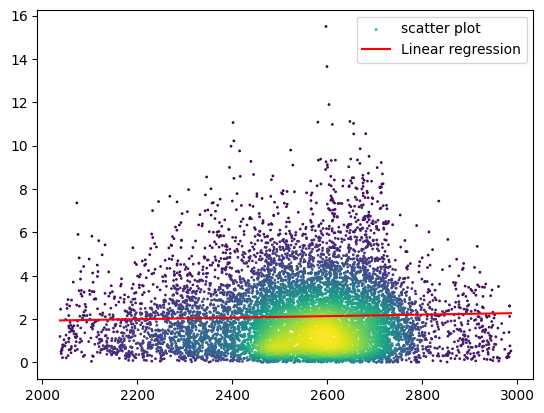

Fitted function: 35.047*10^-5 * x + 1.227
MSE: 2.6708353
R^2: 0.001189589500427246


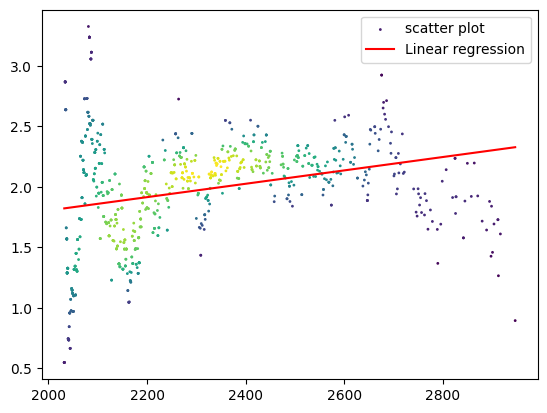

Fitted function: 55.335*10^-5 * x + 0.698
MSE: 0.20669945507541065
R^2: 0.06631826705125943
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220511_1m_epsg2056


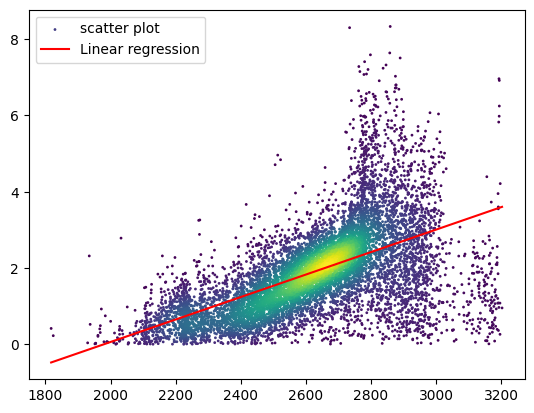

Fitted function: 294.477*10^-5 * x + -5.827
MSE: 0.9029045
R^2: 0.32529693841934204


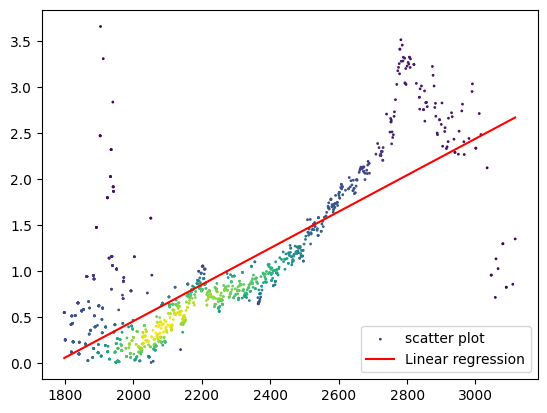

Fitted function: 198.491*10^-5 * x + -3.517
MSE: 0.21814830823459538
R^2: 0.6145694816893361
____________________________________________________________________________________________________ 
 snowmap_2014_ads_100_extent_maskiert_nosnow0_noausreisser


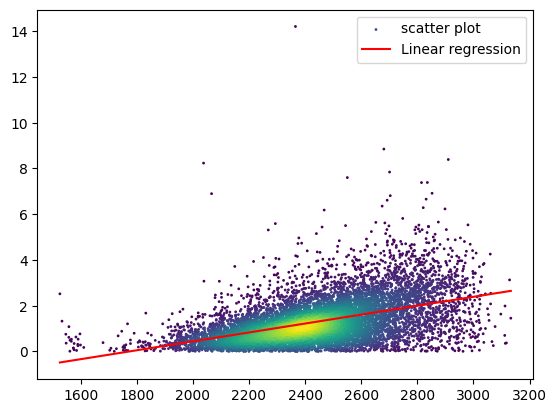

Fitted function: 194.857*10^-5 * x + -3.456
MSE: 0.7070765
R^2: 0.22942286729812622


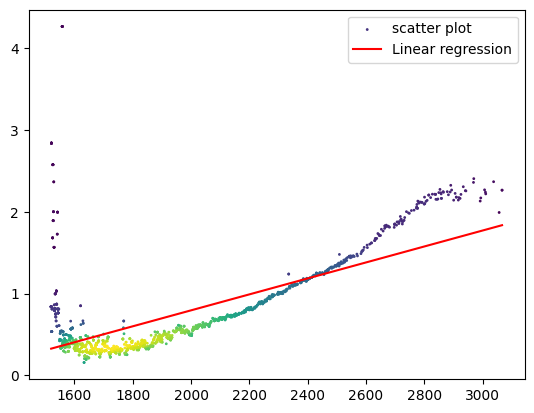

Fitted function: 97.492*10^-5 * x + -1.154
MSE: 0.19630260923657245
R^2: 0.39216549250878663
____________________________________________________________________________________________________ 
 HS_Davos_20200406_2m_epsg2056


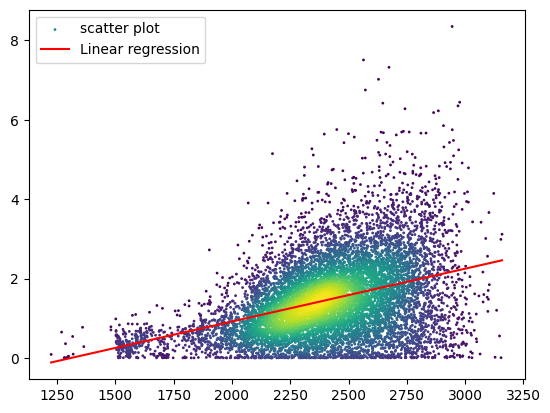

Fitted function: 133.078*10^-5 * x + -1.744
MSE: 0.79827976
R^2: 0.15084600448608398


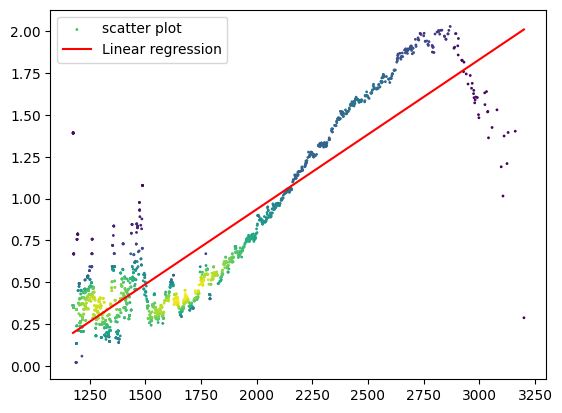

Fitted function: 89.576*10^-5 * x + -0.856
MSE: 0.04964481050468894
R^2: 0.7770997193876579
____________________________________________________________________________________________________ 
 HS_Davos_20211604_2m_epsg2056


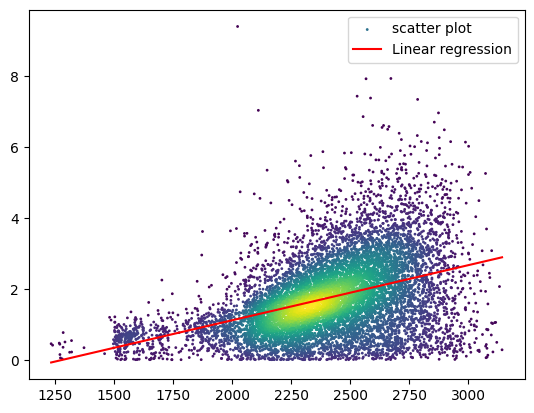

Fitted function: 155.086*10^-5 * x + -1.99
MSE: 0.9735256
R^2: 0.17203569412231445


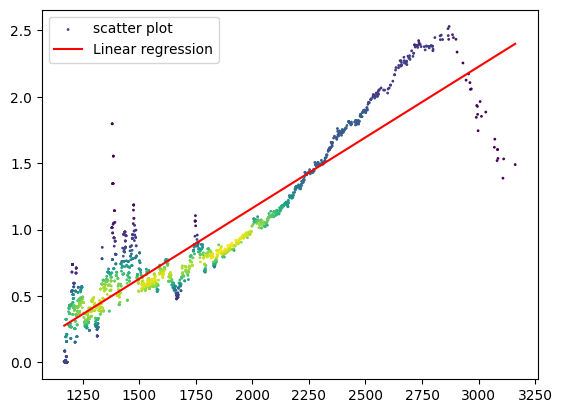

Fitted function: 106.428*10^-5 * x + -0.966
MSE: 0.040083402044893475
R^2: 0.8487460684525
____________________________________________________________________________________________________ 
 snowmap_2013_ads_80_extent_maskiert_nosnow0_noausreisser


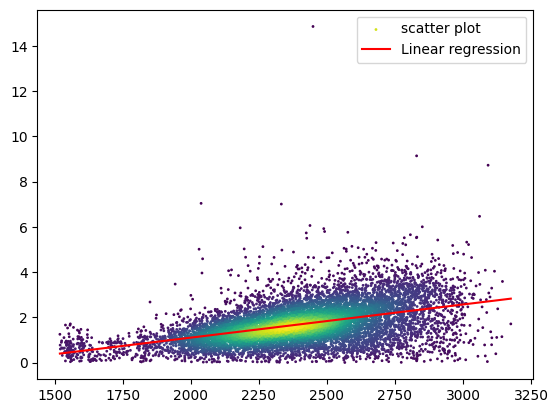

Fitted function: 146.539*10^-5 * x + -1.83
MSE: 0.60725135
R^2: 0.21256566047668457


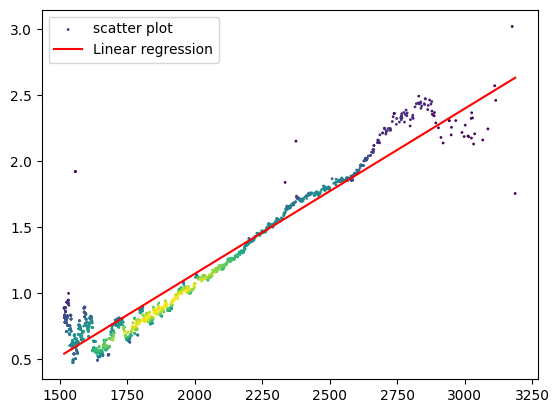

Fitted function: 124.962*10^-5 * x + -1.353
MSE: 0.01918945402313952
R^2: 0.9226922470850512
____________________________________________________________________________________________________ 
 snowmap_2012_ads_80_extent_maskiert_nosnow0_noausreisser


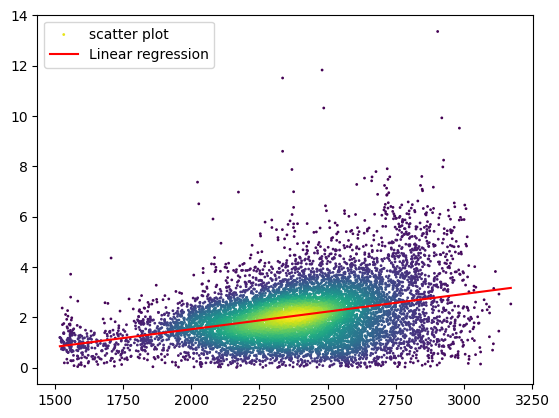

Fitted function: 140.27*10^-5 * x + -1.285
MSE: 1.1454507
R^2: 0.1201215386390686


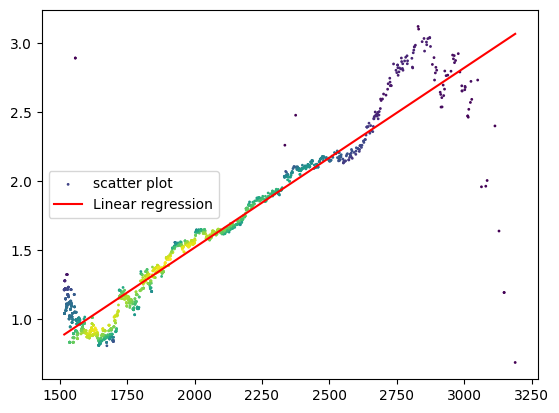

Fitted function: 130.268*10^-5 * x + -1.088
MSE: 0.032387318354239344
R^2: 0.885955339540146
____________________________________________________________________________________________________ 
 snowmap_2015_ads_100_extent_maskiert_nosnow0_noausreisser


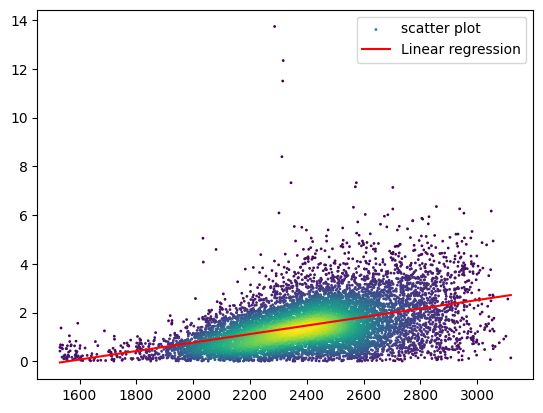

Fitted function: 174.19*10^-5 * x + -2.716
MSE: 0.7737224
R^2: 0.19784170389175415


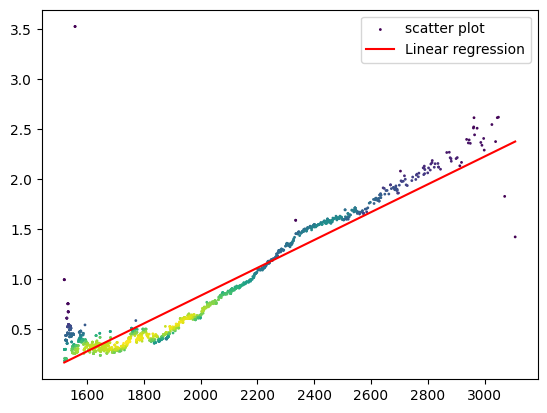

Fitted function: 138.927*10^-5 * x + -1.941
MSE: 0.037234888959574476
R^2: 0.8709239978114458
____________________________________________________________________________________________________ 
 snowmap_20160126_ads_100_extent_maskiert_nosnow0_noausreisser


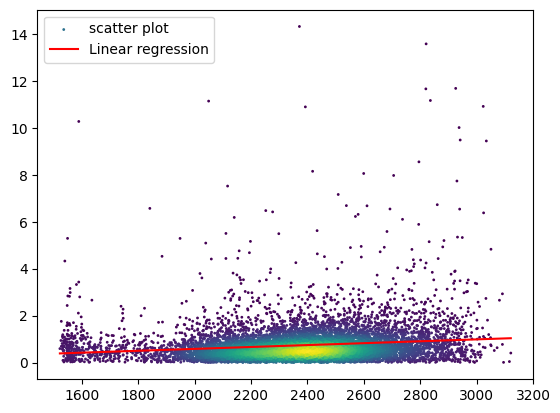

Fitted function: 40.498*10^-5 * x + -0.229
MSE: 0.560434
R^2: 0.022319436073303223


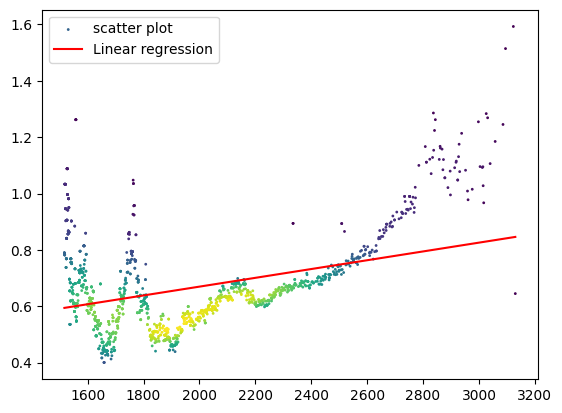

Fitted function: 15.61*10^-5 * x + 0.357
MSE: 0.022076323212269076
R^2: 0.12769394479912521
____________________________________________________________________________________________________ 
 HS_c_20220223_1m_epsg2056


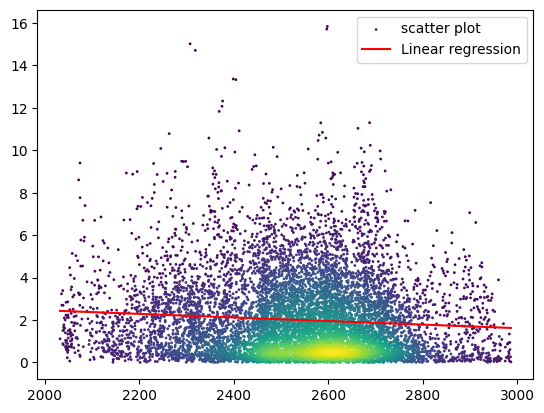

Fitted function: -84.159*10^-5 * x + 4.142
MSE: 3.4778457
R^2: 0.00597614049911499


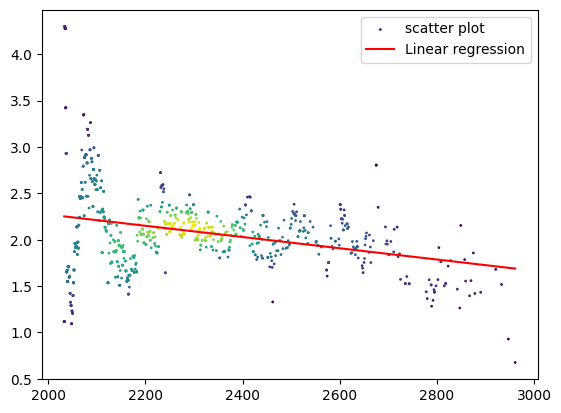

Fitted function: -60.649*10^-5 * x + 3.484
MSE: 0.20554393864979054
R^2: 0.07354566112681127
____________________________________________________________________________________________________ 
 HS_Davos_20170316_2m_epsg2056


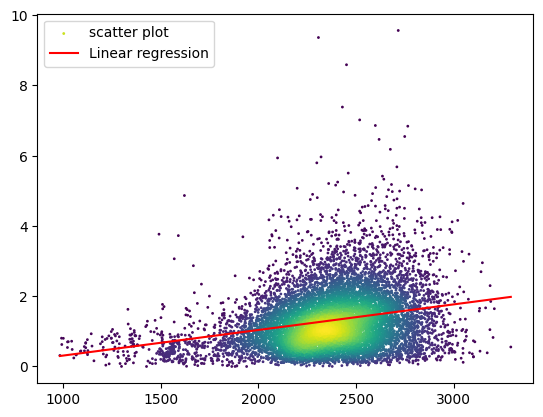

Fitted function: 72.919*10^-5 * x + -0.419
MSE: 0.6439972
R^2: 0.06716680526733398


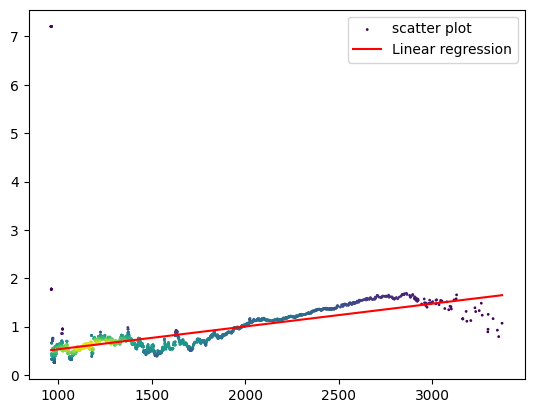

Fitted function: 47.13*10^-5 * x + 0.059
MSE: 0.19328277737984917
R^2: 0.2503192594848811
____________________________________________________________________________________________________ 
 HS_Davos_20180411_2m_epsg2056


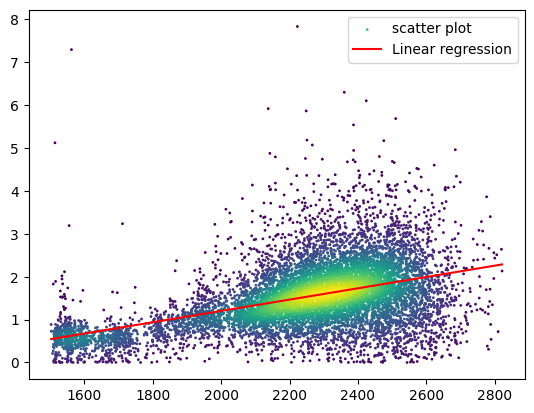

Fitted function: 132.052*10^-5 * x + -1.439
MSE: 0.47425416
R^2: 0.22276979684829712


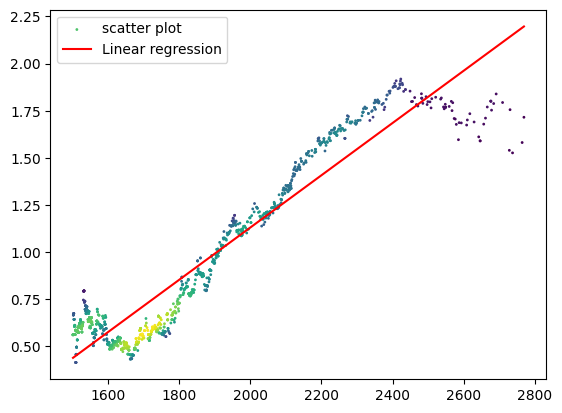

Fitted function: 138.762*10^-5 * x + -1.645
MSE: 0.019578770152941412
R^2: 0.8937517987148815
____________________________________________________________________________________________________ 
 snowmap_20160420_ads_100_extent_maskiert_nosnow0_noausreisser


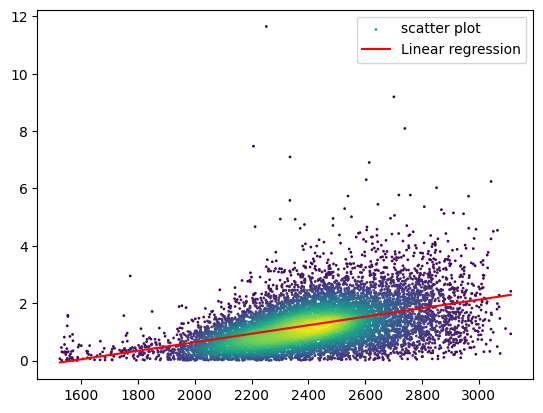

Fitted function: 148.619*10^-5 * x + -2.336
MSE: 0.5275949
R^2: 0.20285451412200928


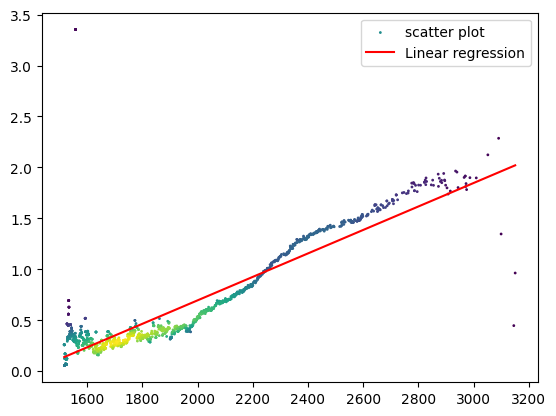

Fitted function: 115.182*10^-5 * x + -1.609
MSE: 0.06520172262668507
R^2: 0.7212184891192952
____________________________________________________________________________________________________ 
 HS_Laucherenalp_20220224_2m_epsg2056


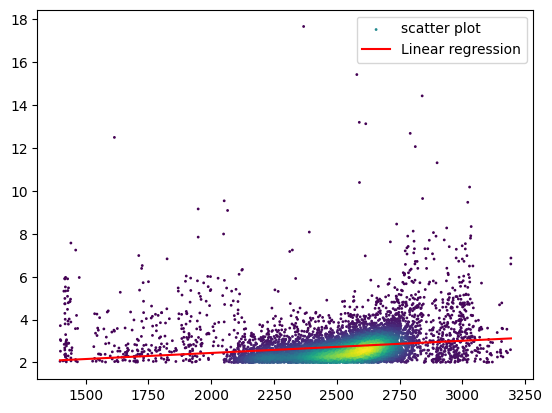

Fitted function: 56.787*10^-5 * x + 1.309
MSE: 0.6274812
R^2: 0.02947622537612915


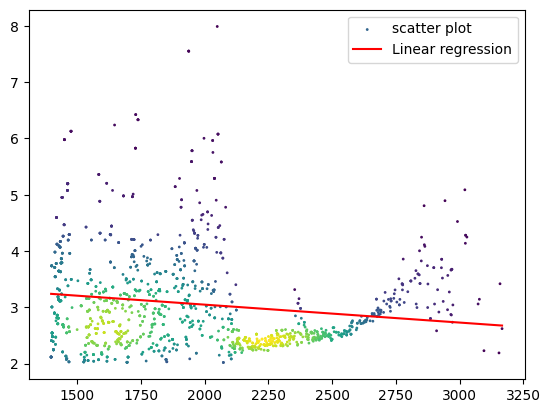

Fitted function: -31.827*10^-5 * x + 3.684
MSE: 0.7225374049686539
R^2: 0.022600178850669228
____________________________________________________________________________________________________ 
 snowmap_2010_ads_80_extent_maskiert_nosnow0_noausreisser


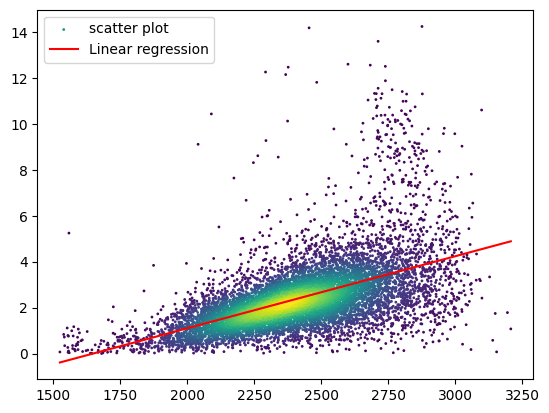

Fitted function: 313.271*10^-5 * x + -5.165
MSE: 1.4963657
R^2: 0.29827964305877686


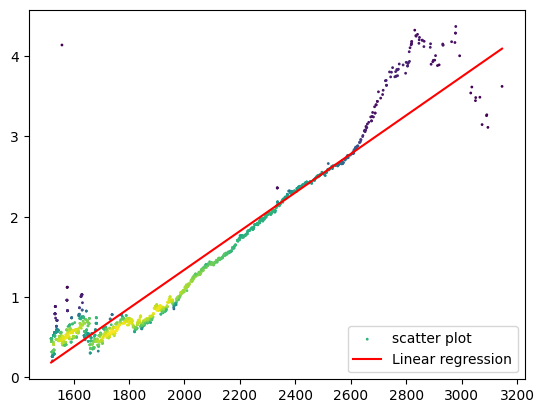

Fitted function: 240.247*10^-5 * x + -3.465
MSE: 0.07013078225139105
R^2: 0.9185022273473761


In [54]:
for index, series in df.iterrows(): 
    print("_"*100, "\n", series.name)
    mapping = get_mapping(series)
    plot_map(mapping)
    new_mapping = plot_slices(mapping)